In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
%matplotlib inline


In [2]:
class midterm_Econ602:
    """
    A simple one sector growth model solved by discrete state space technique.

    Parameters
    ----------
    β : float
        Time discounting parameter
    σ : float
        Risk-aversion parameter
    δ : float
        depreciation rate
    nk : int
        Number of points in k grid
    tol : float
        Error tolerance in iteration
    maxit : int
        Maximum number of iterations
    μ : float
        preference parameter
    θ : float
        produtivity parameter
    """

    def __init__(self,
                β=.99,         # time discount rate
                σ=2,           # risk aversion
                δ=0.025,        # depreciation rate
                θ = 0.36,        # productivity parameter
                μ = 0.34,
                nk=100,          # number of points in k grid
                tol=1e-9,       # error tolerance in iteration
                maxit=10000):

        # Save parameters
        self.β, self.σ, self.μ, self.δ, self.θ = β, σ, μ, δ, θ
        self.nk = nk 
        self.tol = tol
        self.maxit = maxit
    
        
        # Create grids and discretize state space
        
        self.ls = (1 - θ)/(((1 - μ)/μ) + 1 - θ - (((1 - μ)*δ*θ)/(μ*((1/β) - (1 - δ))))) 
        #steady state labor
        self.ks = self.ls * (((1/β) - (1 - δ))/θ)**(1/(θ - 1)) 
        #steady state capital

        self.kgrid = np.linspace(0.8*self.ks, 1.2*self.ks, nk)

        # Allocate memory for return, value, and policy functions
    
        self.v = np.zeros((nk)) 
        # initialize value function v which is the size nk vector, initial guess
        self.gk_index = np.empty((nk)) 
        # index of capital stock from 0 to nk-1
        self.gpr = np.empty((nk)) 
        # vector to store what is optimal k' given k (policy function)
        self.Ret = np.zeros((nk,nk)) 
        # return matrix
        self.l = np.zeros((nk,nk))
        # labor given k and k'
        self.labor = np.zeros(nk)
        # vector to store optimal labor choices
        self.cons = np.zeros(nk)
        # vector to store optimal consumption
        
        # solving for the optimal labor choices given k and k' with implicit equation
        
        for i in range(nk):
            for j in range(nk):
                lhs = (self.kgrid[j] - ((1 - δ) * self.kgrid[i]))/(self.kgrid[i]**θ)
                if lhs >= 1: # trying to control the case where the implicit equation 
                    # yields labor choice that is greater than 1 given certain (k, k') which is not possible
                    self.l[i, j] = 1
                else:
                    self.l[i, j] = so.brentq(eqn_solve, 0.000000001, 1, args = (μ, θ, δ, self.kgrid[i], self.kgrid[j]))
        
        # Build the return function
        
        for i in range(nk):
            for j in range(nk): # 0 to (nk - 1)
                c = (self.kgrid[i]**θ)*(self.l[i,j]**(1 - θ))+(1-δ)*self.kgrid[i]-self.kgrid[j] 
                #kgrid[j] = k' (next period capital), gives first row for the return matrix when i = 1
                # meaning calculate c for ith value of k and many k' and put in 1st row
                if c <= 0:
                    self.Ret[i,j] = -1e+14
                else: 
                    self.Ret[i,j] = u(c,self.l[i,j],μ,σ)
                
   
    # Below is the value function iteration function
        
    def solve(self):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Alloc memory to store next iterate of value function
        v_upd = np.zeros((self.nk)) 
        #temporary variable to store new v = v_1, v_2 ... 1st 2nd ... iteration of guessed v_0
        
        # Main loop
        while dist > self.tol and self.maxit > it:
           
            for ik in range(self.nk):
                current_max = -1e14
                for ik_next in range(self.nk):
                    m = self.Ret[ik,ik_next] + self.β * self.v[ik_next] 
                    #RHS of the Bellman Equation without maximum for all
                    #possible combinations of k and k'
            
                    if m > current_max:
                        current_max = m      
                
                self.v[ik] = current_max  
                # update value of v from each row of of return matrix - each row contains the maximum
                # value of value function for each k. maximized value of 1st row in return matrix goes to the 1st row and so on
            
            dist = np.max(np.abs(v_upd - self.v)) 
            # v_upd was what we started with v_0, becomes v_1, v_2 ... in next line
            v_upd[:] = self.v[:]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")
            self.it = it
        return None    
        
    # This is to recover policy function after the value function has converged
    
    def kpr_policy(self):

    
    # Compute gpr and its index: best index in kgrid given ik  
    
        for ik in range(self.nk):
            current_max = -1e14
            for ik_next in range(self.nk):
                m = self.Ret[ik,ik_next] + self.β * self.v[ik_next] 
                #using the converged value of v, not doing value function iteration
                if m > current_max:
                    current_max = m
                    current_max_index = ik_next
            self.gk_index[ik] = current_max_index
            self.gpr[ik] = self.kgrid[current_max_index]
            self.labor[ik] = self.l[ik, current_max_index]
            self.cons[ik] = (self.kgrid[ik]**self.θ)*(self.l[ik,current_max_index]**(1 - self.θ))+(1-self.δ)*self.kgrid[ik]-self.kgrid[current_max_index]
        return None 
        
        
# Just to compute utility            

def u(c,l, μ, σ):
    return ((c**μ * (1 - l)**(1 - μ))**(1 - σ))/(1 - σ)

# implicit function to compute l
def eqn_solve(l, μ, θ, δ, k1, k2):
    return((((1 - μ)*(k2 - (1 - δ)*k1))/(μ*k1**θ)) - (l**(1 - θ) * (((1 - μ)/μ) + 1 - θ - ((1 - θ)/l))))


In [3]:
solution = midterm_Econ602(β=.99,         # time discount rate
                        σ=2,           # risk aversion
                        δ=0.025,        # depreciation rate
                        θ = 0.36,        # productivity parameter
                        μ = 0.34,
                        nk=500,          # number of points in k grid
                        tol=1e-6,       # error tolerance in iteration
                        maxit=10000)

In [4]:
solution.solve()
solution.kpr_policy()

Running iteration 25 with dist of 1.0722009051062855
Running iteration 50 with dist of 0.8339807655587634
Running iteration 75 with dist of 0.6486880527796615
Running iteration 100 with dist of 0.504563423039059
Running iteration 125 with dist of 0.3922524092256623
Running iteration 150 with dist of 0.30443266863827034
Running iteration 175 with dist of 0.2363418712741634
Running iteration 200 with dist of 0.1835568364369351
Running iteration 225 with dist of 0.1426082265732873
Running iteration 250 with dist of 0.11082130428363257
Running iteration 275 with dist of 0.08613692820379981
Running iteration 300 with dist of 0.0669608409916691
Running iteration 325 with dist of 0.0520606024011272
Running iteration 350 with dist of 0.040478907075396364
Running iteration 375 with dist of 0.0314764476876519
Running iteration 400 with dist of 0.024477181036331785
Running iteration 425 with dist of 0.01903510512127582
Running iteration 450 with dist of 0.01480416485560454
Running iteration 475 w

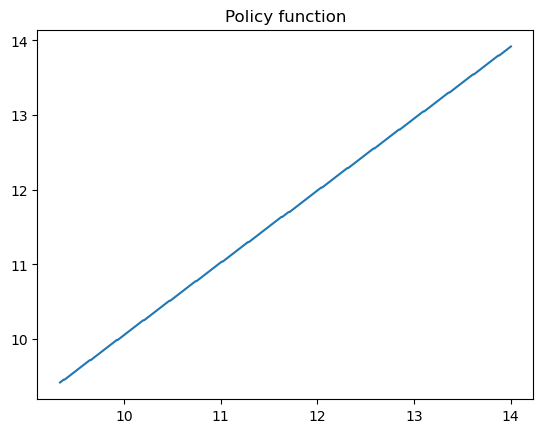

In [5]:
fig, ax = plt.subplots()
ax.set_title("Policy function")

    
ax.plot(solution.kgrid, solution.gpr, label="$k'$")
plt.show()

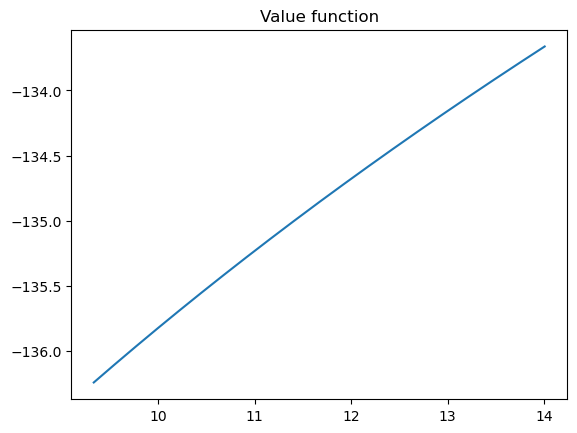

In [6]:
fig, ax = plt.subplots()
ax.set_title("Value function")

# Extract a suitable plot grid
    
ax.plot(solution.kgrid, solution.v, label="$v$")
    

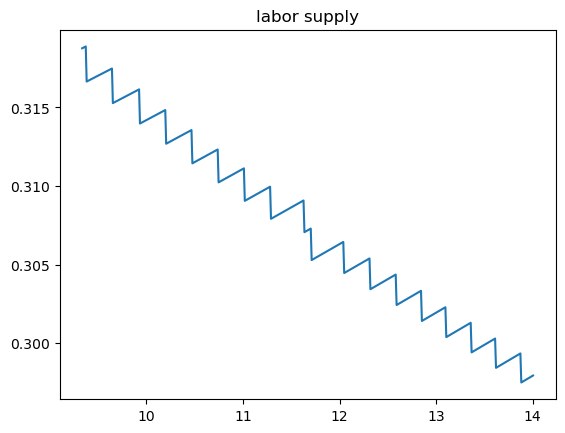

In [7]:
fig, ax = plt.subplots()
ax.set_title("labor supply")

    
ax.plot(solution.kgrid, solution.labor, label="$k'$")
plt.show()

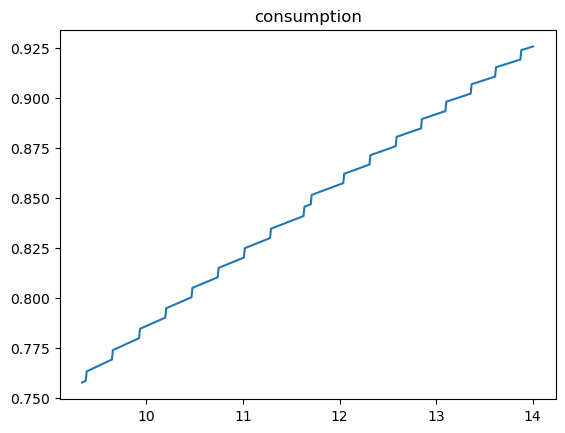

In [8]:
fig, ax = plt.subplots()
ax.set_title("consumption")

    
ax.plot(solution.kgrid, solution.cons, label="$k'$")
plt.show()

In [ ]:
# COMMENT ON THE SHAPE OF LABOR SUPPLY:

# Ideally, if we were able to deal with the continuous data, we would have seen the labor supply
# decreasing consistently with the increase in current capital stock. This is because when the current
# capital increases, a person feels richer and wants to work less thus decreasing the labor supply. 
# In other words, when current capital increases, the marginal productivity of labor increases thus reducing the labor 
#supply.

# However, when dealing with discrete state space technique, even though the person does not want
# to invest as much after the increase in current capital, he/she is forced to invest the same amount
# (i.e. k - k' remains the same) because there are not enough finer points/grids in the discrete space to 
# jump to. Due to this, the labor supply increases locally in order to maintain the same investment 
# level even though the current capital increases.

# But,eventually, the labor supply has to follow the global optimal, which is the decrease in the labor 
# supply with the increase in current capital. Again, due to discrete state space, there are not grids
# for smooth transition from higher to lower labor supply. Due to the discrete nature, the amount of
# investment required (difference between k' and k) decreases suddenly, forcing labor supply curve to 
# fall abruptly.
 
# Thus, we observe the saw like labor supply curve because of the discrete nature of the system and
# the system trying to navigate through different local optimal points before converging to the 
# global optimum. 

# One way to address this issue would be by using more finer discretization.